In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import lightgbm as lgb
import xgboost as xgb
from keras.layers import LSTM, Dropout, Dense, Conv1D, Flatten

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from pypfopt import EfficientFrontier, risk_models, expected_returns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
sp500_companies = pd.read_csv('sp500_companies.csv')
sp500_index = pd.read_csv('sp500_index.csv')
sp500_stocks = pd.read_csv('sp500_stocks.csv')

sp500_companies.head(),sp500_index.head(),sp500_stocks.head()

(  Exchange Symbol              Shortname               Longname  \
 0      NMS   AAPL             Apple Inc.             Apple Inc.   
 1      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
 2      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
 3      NMS   AMZN       Amazon.com, Inc.       Amazon.com, Inc.   
 4      NMS   GOOG          Alphabet Inc.          Alphabet Inc.   
 
                    Sector                        Industry  Currentprice  \
 0              Technology            Consumer Electronics        242.84   
 1              Technology                  Semiconductors        142.44   
 2              Technology       Software - Infrastructure        443.57   
 3       Consumer Cyclical                 Internet Retail        227.03   
 4  Communication Services  Internet Content & Information        176.49   
 
        Marketcap        Ebitda  Revenuegrowth           City State  \
 0  3670720643072  1.346610e+11          0.061      Cupertino

**Data Preprocessing**

In [3]:
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])

sp500_index = sp500_index.sort_values('Date')
sp500_stocks = sp500_stocks.sort_values('Date')
sp500_companies.fillna(0, inplace=True)
sp500_stocks.fillna(0, inplace=True)

sp500_index.set_index('Date', inplace=True)

**Exploratory Data Analysis (EDA)**

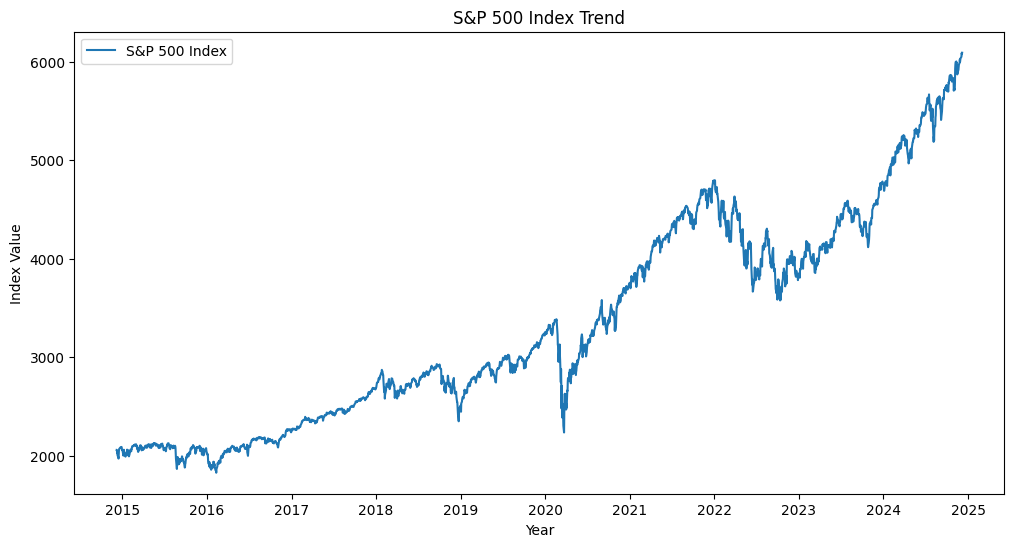

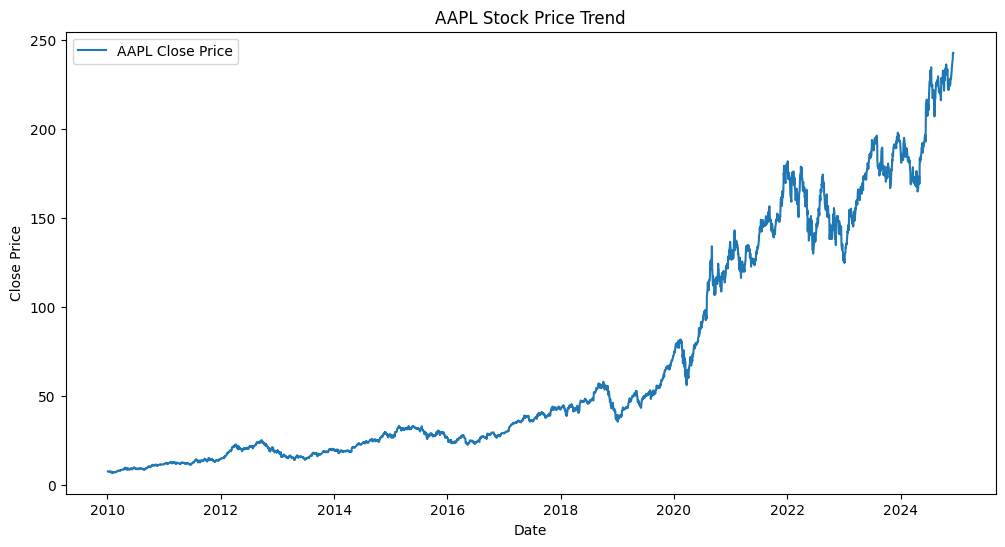

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_index.index, sp500_index['S&P500'], label="S&P 500 Index")
plt.title("S&P 500 Index Trend")
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.show()

aapl_stock = sp500_stocks[sp500_stocks['Symbol'] == 'AAPL']
plt.figure(figsize=(12, 6))
plt.plot(aapl_stock['Date'], aapl_stock['Close'], label='AAPL Close Price')
plt.title('AAPL Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**Time Series Forecasting**

> 1. ARIMA Model for S&P 500 Prediction

ADF Statistic: 0.8521805271211342
p-value: 0.9924334339061891
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=25245.311, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25326.760, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25312.793, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25314.110, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=25311.776, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=25312.050, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=25246.302, Time=0.90 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=25312.891, Time=0.82 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=25311.385, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=25311.812, Time=0.43 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25312.476, Time=0.50 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.54 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=25242.041, Time=2.25 sec
 ARIMA(1,0,2)(0,0,0)[0] interc

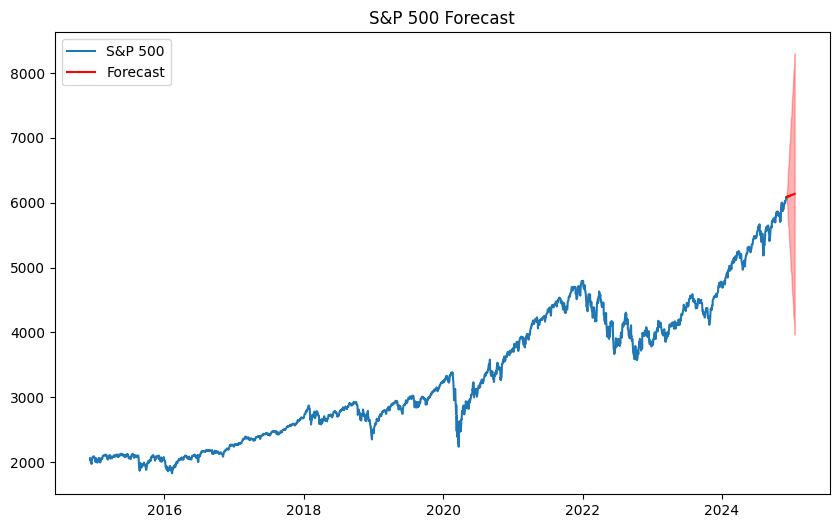

In [5]:
result = sm.tsa.adfuller(sp500_index['S&P500'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

sp500_diff = sp500_index['S&P500'].diff().dropna()

arima_model = auto_arima(sp500_diff, seasonal=False, trace=True, stepwise=True)

n_periods = 30
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)
forecast_dates = pd.date_range(sp500_index.index[-1], periods=n_periods, freq='B')

plt.figure(figsize=(10,6))
plt.plot(sp500_index.index, sp500_index['S&P500'], label='S&P 500')
plt.plot(forecast_dates, forecast.cumsum() + sp500_index['S&P500'].iloc[-1], label='Forecast', color='red')
plt.fill_between(forecast_dates, conf_int[:, 0].cumsum() + sp500_index['S&P500'].iloc[-1], 
                 conf_int[:, 1].cumsum() + sp500_index['S&P500'].iloc[-1], color='red', alpha=0.3)
plt.title('S&P 500 Forecast')
plt.legend()
plt.show()

> 2. LSTM Model for Stock Price Prediction

Epoch 1/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0016 - val_loss: 7.4347e-04
Epoch 2/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.1564e-04 - val_loss: 0.0011
Epoch 3/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.1706e-04 - val_loss: 5.2031e-04
Epoch 4/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 1.1108e-04 - val_loss: 0.0018
Epoch 5/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 1.0995e-04 - val_loss: 5.3985e-04
Epoch 6/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 7.8148e-05 - val_loss: 3.7972e-04
Epoch 7/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 7.1205e-05 - val_loss: 7.2533e-04
Epoch 8/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 7.3552e-05 - val_loss: 0.0018
Epoch 9/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 8.1521e-05 - val_loss: 4.9890e-04
Epoch 10/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 8.1864e-05 - val_loss: 2.2632e-04
Epoch 11/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 5.

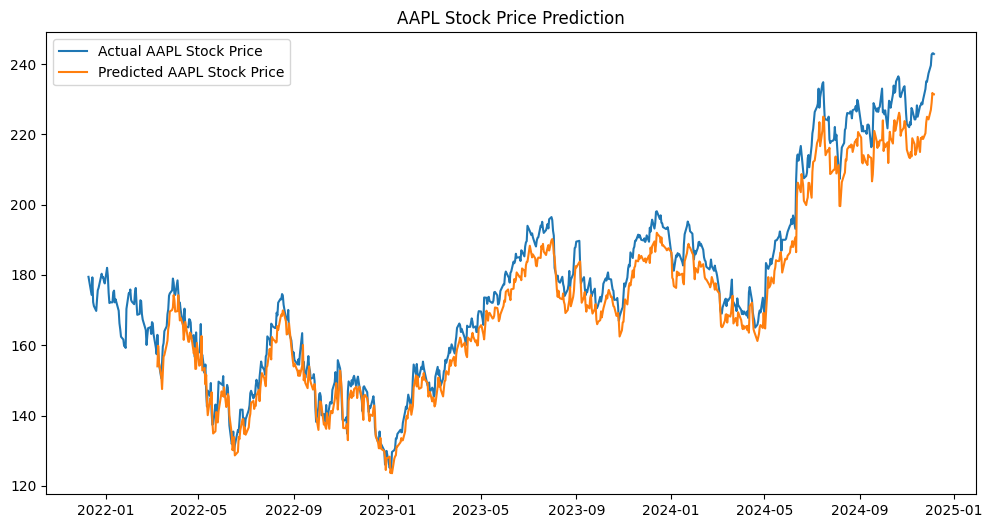

In [6]:
aapl_stock.set_index('Date', inplace=True)
aapl_prices = aapl_stock['Close'].values.reshape(-1,1)

scaler = MinMaxScaler()
aapl_prices_scaled = scaler.fit_transform(aapl_prices)

train_size = int(len(aapl_prices_scaled) * 0.8)
train_data = aapl_prices_scaled[:train_size]
test_data = aapl_prices_scaled[train_size:]

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data)-seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# model = Sequential()
# model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=100, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(25))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=8, epochs=20, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(12,6))
plt.plot(aapl_stock.index[train_size:], aapl_stock['Close'][train_size:], label='Actual AAPL Stock Price')
plt.plot(aapl_stock.index[train_size+seq_length:], predictions, label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

In [7]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

evaluate_model(y_test, predictions)

RMSE: 173.1772833137725, MAE: 171.27814863339074, R2: -2123659.2034093332


[*********************100%***********************]  1 of 1 completed

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


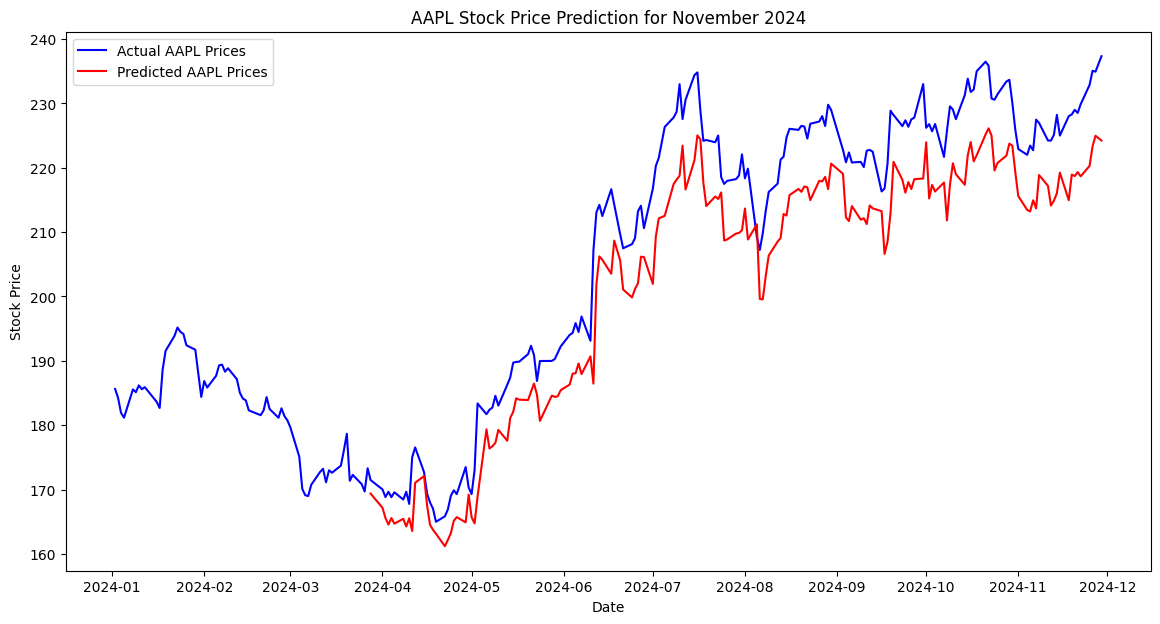

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Fetch data from Yahoo Finance
aapl = yf.download("AAPL", start="2024-01-01", end="2024-11-30")
aapl['Date'] = aapl.index
aapl_prices = aapl['Close'].values.reshape(-1, 1)

# Scale the data using the same scaler
# scaler = MinMaxScaler()
aapl_prices_scaled = scaler.transform(aapl_prices)

# Create sequences for prediction
seq_length = 60
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X_future = create_sequences(aapl_prices_scaled, seq_length)

# Predict November 2024 stock prices
predictions = model.predict(X_future)
predictions_rescaled = scaler.inverse_transform(predictions)

# Plot real vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(aapl['Date'], aapl['Close'], label="Actual AAPL Prices", color='blue')
plt.plot(aapl['Date'][seq_length:], predictions_rescaled, label="Predicted AAPL Prices", color='red')
plt.title("AAPL Stock Price Prediction for November 2024")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


**Portfolio Optimization**

In [9]:
# stock_prices = sp500_stocks.pivot(index='Date', columns='Symbol', values='Close').dropna()

# mean_returns = expected_returns.mean_historical_return(stock_prices)
# cov_matrix = risk_models.sample_cov(stock_prices)

# ef = EfficientFrontier(mean_returns, cov_matrix)
# weights = ef.max_sharpe()
# cleaned_weights = ef.clean_weights()

# print(cleaned_weights)
# ef.portfolio_performance(verbose=True)

**Visualization**

In [10]:
import nbformat
print(nbformat.__version__)

5.10.4


In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sp500_index.index, y=sp500_index['S&P500'], mode='lines', name='S&P 500'))
fig.update_layout(title='S&P 500 Index Over Time', xaxis_title='Date', yaxis_title='Index Value')
fig.show()

aapl_candlestick = aapl_stock[['Open', 'High', 'Low', 'Close']].copy()
aapl_candlestick['Date'] = aapl_stock.index

fig = go.Figure(data=[go.Candlestick(x=aapl_candlestick['Date'],
                                      open=aapl_candlestick['Open'],
                                      high=aapl_candlestick['High'],
                                      low=aapl_candlestick['Low'],
                                      close=aapl_candlestick['Close'])])

fig.update_layout(title='AAPL Stock Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


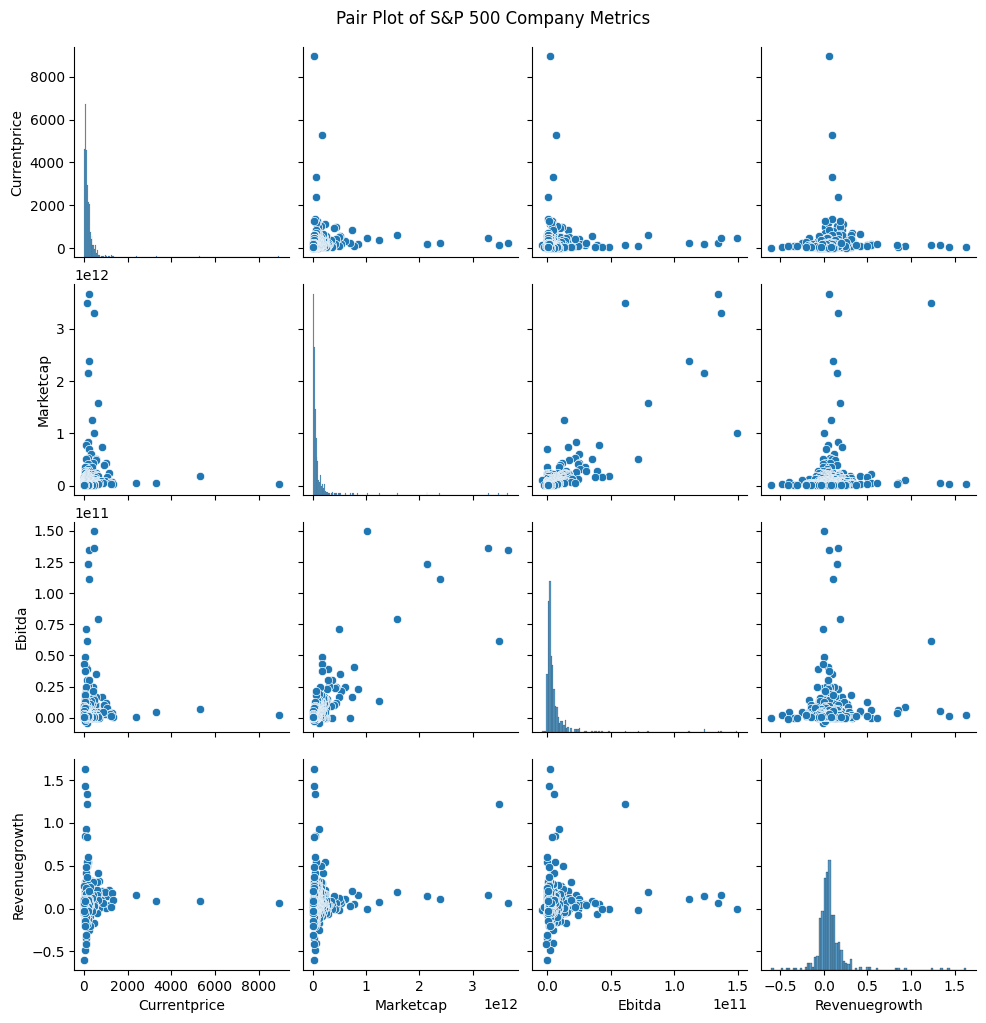

In [12]:
sns.pairplot(sp500_companies[['Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth']])
plt.suptitle('Pair Plot of S&P 500 Company Metrics', y=1.02)
plt.show()